In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)


import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_consistent_length

def uplift_curve(y_true, uplift, treatment):


    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    desc_score_indices = np.argsort(uplift, kind="mergesort")[::-1]
    y_true, uplift, treatment = y_true[desc_score_indices], uplift[desc_score_indices], treatment[desc_score_indices]

    y_true_ctrl, y_true_trmnt = y_true.copy(), y_true.copy()

    y_true_ctrl[treatment == 1] = 0
    y_true_trmnt[treatment == 0] = 0

    distinct_value_indices = np.where(np.diff(uplift))[0]
    threshold_indices = np.r_[distinct_value_indices, uplift.size - 1]

    num_trmnt = stable_cumsum(treatment)[threshold_indices]
    y_trmnt = stable_cumsum(y_true_trmnt)[threshold_indices]

    num_all = threshold_indices + 1

    num_ctrl = num_all - num_trmnt
    y_ctrl = stable_cumsum(y_true_ctrl)[threshold_indices]

    curve_values = (np.divide(y_trmnt, num_trmnt, out=np.zeros_like(y_trmnt), where=num_trmnt != 0) -
                    np.divide(y_ctrl, num_ctrl, out=np.zeros_like(y_ctrl), where=num_ctrl != 0)) * num_all

    if num_all.size == 0 or curve_values[0] != 0 or num_all[0] != 0:
        # Add an extra threshold position if necessary
        # to make sure that the curve starts at (0, 0)
        num_all = np.r_[0, num_all]
        curve_values = np.r_[0, curve_values]

    return num_all, curve_values


def perfect_uplift_curve(y_true, treatment):

    check_consistent_length(y_true, treatment)
    
    y_true, treatment = np.array(y_true), np.array(treatment)

    cr_num = np.sum((y_true == 1) & (treatment == 0))  # Control Responders
    tn_num = np.sum((y_true == 0) & (treatment == 1))  # Treated Non-Responders

    # express an ideal uplift curve through y_true and treatment
    summand = y_true if cr_num > tn_num else treatment
    perfect_uplift = 2 * (y_true == treatment) + summand

    return uplift_curve(y_true, perfect_uplift, treatment)


def uplift_auc_score(y_true, uplift, treatment):
  

    check_consistent_length(y_true, uplift, treatment)
    
    y_true, uplift, treatment = np.array(y_true), np.array(uplift), np.array(treatment)

    x_actual, y_actual = uplift_curve(y_true, uplift, treatment)
    x_perfect, y_perfect = perfect_uplift_curve(y_true, treatment)
    x_baseline, y_baseline = np.array([0, x_perfect[-1]]), np.array([0, y_perfect[-1]])

    auc_score_baseline = auc(x_baseline, y_baseline)
    auc_score_perfect = auc(x_perfect, y_perfect) - auc_score_baseline
    auc_score_actual = auc(x_actual, y_actual) - auc_score_baseline

    return auc_score_actual / auc_score_perfect

# Load data and split

In [3]:
# функция для уменьшения объёма датасета за счёт изменения типов
def reduce_mem_usage(df, verbose=True): 
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
import sys
from sklearn.model_selection import train_test_split
import logging
import pickle

log_format = '[%(asctime)s] %(name)-25s %(levelname)-8s %(message)s'
logging.basicConfig(
    format=log_format,
    level=logging.INFO,
)
logger = logging.getLogger(__name__)

from load_and_prepare import (
    prepare_clients,
    prepare_products,
    prepare_purchases,
    load_train,
    load_test,
)


logger.info('Loading features...')
with open('features.pkl', 'rb') as f:
    features: pd.DataFrame = pickle.load(f)
logger.info('Features are loaded')

logger.info(f'Features shape: {features.shape}')

logger.info('Preparing data sets...')
features.set_index('client_id', inplace=True)

features = reduce_mem_usage(features)


features = features.replace(-np.inf, 0)

train = load_train()
test = load_test()
indices_train = train.index
indices_test = test.index

X_train = features.loc[indices_train, :]
treatment_train = train.loc[indices_train, 'treatment_flg'].values
target_train = train.loc[indices_train, 'target'].values
# y_valid = make_z(treatment_train, target_train)

X_test = features.loc[indices_test, :]

RANDOM_STATE = 12

indices_learn, indices_valid = train_test_split(
    train.index,
    test_size=0.3,
    random_state=RANDOM_STATE + 1,
)

X_learn = features.loc[indices_learn, :]
treatment_learn = train.loc[indices_learn, 'treatment_flg'].values
target_learn = train.loc[indices_learn, 'target'].values
# y_learn = make_z(treatment_learn, target_learn)

X_valid = features.loc[indices_valid, :]
treatment_valid = train.loc[indices_valid, 'treatment_flg'].values
target_valid = train.loc[indices_valid, 'target'].values

# y_valid = make_z(treatment_valid, target_valid)
logger.info('Data sets prepared')





Mem. usage decreased to 255.69 Mb (68.1% reduction)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_learn = scaler.fit_transform(X_learn)
print(X_learn)

[[-0.44912854 -0.76453884  1.07641328 ...  0.15965862 -0.05842654
  -0.07412983]
 [ 2.22653409 -0.76453884 -0.9290112  ... -1.48345675 -1.15039334
  -1.19302592]
 [-0.44912854 -0.76453884  1.07641328 ...  1.36039677  0.41930894
   0.31318035]
 ...
 [-0.44912854 -0.76453884  1.07641328 ...  0.91801956  0.31693705
   0.35621481]
 [-0.44912854  1.30797803 -0.9290112  ...  0.53883909  0.21456516
   0.27014588]
 [-0.44912854 -0.76453884  1.07641328 ...  0.28605211  0.31693705
   0.48531821]]


In [6]:
X_valid = scaler.transform(X_valid)
print(X_valid)

[[-0.44912854 -0.76453884  1.07641328 ... -1.98903071 -1.457509
  -1.53730164]
 [-0.44912854 -0.76453884  1.07641328 ... -1.35706326 -1.04802145
  -1.14999146]
 [-0.44912854 -0.76453884  1.07641328 ...  0.34924885  0.07806931
   0.18407695]
 ...
 [ 2.22653409 -0.76453884 -0.9290112  ...  0.22285536  0.14631724
   0.0119391 ]
 [ 2.22653409 -0.76453884 -0.9290112  ... -1.16747303 -1.08214541
  -1.02088806]
 [-0.44912854 -0.76453884  1.07641328 ...  1.10760979  1.13591215
   1.17386965]]


In [7]:
NEW = pd.DataFrame(X_valid, columns = features.columns)
NEW_train = pd.DataFrame({'treatment_flg':treatment_valid,'target':target_valid})


# Training

### признаки со стандартизацией

In [25]:
from pprint import pprint

batch_size = [200,10000]

n_steps = [1]

epoch = [2]

alpha = [float(x) for x in np.linspace(0.1,0.9,num=5)]

param_grid = {
              'batch_size':batch_size,
              'epoch':epoch,
              'n_steps':n_steps,
              'alpha':alpha
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'alpha': [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9],
 'batch_size': [200, 10000],
 'epoch': [2],
 'n_steps': [1]}


In [26]:
#batch_size = 200
best_auqc = 0
for params in grid_list:
    print("--------iteration---------", params)
    clf=TabNetClassifier(n_steps=params['n_steps'], seed = 3)


    T_train = treatment_learn


    clf.fit(
        X_train=X_learn,T_train = T_train, y_train=target_learn,
        max_epochs=params['epoch'], patience=20,batch_size=params['batch_size'], num_workers=0,
        weights=1, drop_last=False,alpha = params['alpha']
    ) 

    from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

    all_res_uplift = []
    all_res_auqc = []
    all_res_rank_correlation = []
    all_res_auuc = []

    for j in range( 1, 101, 1):

        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            NEW.index,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )


        X_valid = NEW.loc[indices_valid_new, :].values
        treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = NEW_train.loc[indices_valid_new, 'target'].values

    #     print(X_valid)
        preds = clf.predict_proba(X_valid)
        valid_pred  = preds.reshape(-1)

        # valid_pred = clf.predict(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

        valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
        tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
        auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

        all_res_uplift.append(valid_scores)
        all_res_auqc.append(AUQC)
        all_res_rank_correlation.append(tau)
        all_res_auuc.append(auuc)

    print('Число замеров', j)
    print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
    print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
    print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
    print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
    
    if (np.mean(all_res_auqc) > best_auqc):
        best_auqc = np.mean(all_res_auqc)
        best_param = params
        

--------iteration--------- {'alpha': 0.1, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.86495 |  0:00:34s
epoch 1  | loss: 1.8735  |  0:01:08s
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  -0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlatio

Kendal uplift rank correlation =  -0.24845199749997662 with p_value =  0.3840882494738521
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Число замеров

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift ran

Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.09200874124564723 with p_value =  0.7165029052613135
Kendal uplift rank correlation =  -0.13801311186847084 with p_value =  0.5859565771946524
Kendal uplift rank correlation =  -0.044946657497549475 with p_value =  0.8574624419592412
Kendal uplift rank correlation =  0.09200874124564723 with p_value =  0.7165029052613135
Kendal uplift rank correlation =  0.23002185311411807 with p_value =  0.36396207510247747
Kendal uplift rank correlation =  0.046004370622823615 with p_value =  0.8559215597687728
Kendal uplift rank correlation =  -0.31462660248284624 with p_value =  0.20866778769826422
Kendal uplift rank correlation =  0.13801311186847084 with p_value =  0.5859565771946524
Kendal uplift rank correlation =  0.046004370622823615 with p_value =  0.8559215597687728
Kendal uplift rank correlation =  -0.3680349649825889 with p_value =  0.146349826662573
Kendal uplift rank correlation =  0.179786629

Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0

Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.02222222222

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correla

Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Число замеров 100
AUQC: mean:  -375770.90171822923 | std:  345337.26684621436
uplift30%: mean:  0.03500383530505266 | std:  0.009476711911084757
Kendall_rank_correlation: mean:  -0.1293333333333333 | std:  0.1771137993422479
AUUC: mean:  -0.006340931015741731 | std:  0.005689970859755044
--------iteration--------- {'alpha': 0.9, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.73084 |  0:00:33s
epoch 1  | loss: 0.71142 |  0:01:07s
Kendal uplift rank corre

Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift ran

Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlat

In [27]:
print(best_auqc)
print(best_param)

652635.3826161207
{'alpha': 0.5, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}


фиксируем $\alpha$ = 0.5, $batch\_size$ = 200, $n\_steps$ = 1 и подбираем число эпох

In [28]:
best_auqc = 0
for k in range(2,5,1):
    print("----------iteration------------- with num epoch = ",k)
    clf=TabNetClassifier(n_steps=1, seed = 3)

    T_train = treatment_learn

    clf.fit(
        X_train=X_learn,T_train = T_train, y_train=target_learn,
        max_epochs=k, patience=20,batch_size=200, alpha = 0.5
    ) 
    
    from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

    all_res_uplift = []
    all_res_auqc = []
    all_res_rank_correlation = []
    all_res_auuc = []

    for j in range( 1, 101, 1):

        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            NEW.index,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )


        X_valid = NEW.loc[indices_valid_new, :].values
        treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = NEW_train.loc[indices_valid_new, 'target'].values

    #     print(X_valid)
        preds = clf.predict_proba(X_valid)
        valid_pred  = preds.reshape(-1)

        # valid_pred = clf.predict(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

        valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
        tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
        auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

        all_res_uplift.append(valid_scores)
        all_res_auqc.append(AUQC)
        all_res_rank_correlation.append(tau)
        all_res_auuc.append(auuc)

    print('Число замеров', j)
    print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
    print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
    print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
    print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
    
    if (np.mean(all_res_auqc) > best_auqc):
        best_auqc = np.mean(all_res_auqc)
        best_param = k

----------iteration------------- with num epoch =  2
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.52101 |  0:00:30s
epoch 1  | loss: 1.51338 |  0:01:09s
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  734773.2921583771 | std:  350037.6480518595
uplift30%: mean:  0.04802190047209575 | std:  0.01036863235603129
Kendall_rank_correlation: mean:  0.3213333333333333 | std:  0.16795001

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.466666666666

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.33333333333

In [30]:
print("best_auqc = ",best_auqc," with n_epochs = ",3)

best_auqc =  846697.907677134  with n_epochs =  3


## best result auqc = 846697.907677134  with params:
$n\_epochs$ =  3, $\alpha$ = 0.5, $batch\_size$ = 200, $n\_steps$ = 1

In [31]:
clf=TabNetClassifier(n_steps=1, seed = 3)

T_train = treatment_learn

clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=3, patience=20,batch_size=200, alpha = 0.5
) 

from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )


    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)

    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)

print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.52101 |  0:00:33s
epoch 1  | loss: 1.51338 |  0:01:13s
epoch 2  | loss: 1.51278 |  0:01:52s
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  846697.907677134 | std:  321023.80228843057
uplift30%: mean:  0.04138804048401869 | std:  0.009372087570305995
Kendall_rank_correlation: mean:  0.41955555555555557 | 

In [32]:
best_auqc = 0
for k in range(2,10,1):
    print("----------iteration------------- with num epoch = ",k)
    clf=TabNetClassifier(n_steps=1, seed = 3)

    T_train = treatment_learn

    clf.fit(
        X_train=X_learn,T_train = T_train, y_train=target_learn,
        max_epochs=k, patience=20,batch_size=200, alpha = 0.5, num_workers=0,
        weights=1, drop_last=False
    ) 
    
    from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

    all_res_uplift = []
    all_res_auqc = []
    all_res_rank_correlation = []
    all_res_auuc = []

    for j in range( 1, 101, 1):

        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            NEW.index,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )


        X_valid = NEW.loc[indices_valid_new, :].values
        treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = NEW_train.loc[indices_valid_new, 'target'].values

    #     print(X_valid)
        preds = clf.predict_proba(X_valid)
        valid_pred  = preds.reshape(-1)

        # valid_pred = clf.predict(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

        valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
        tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
        auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

        all_res_uplift.append(valid_scores)
        all_res_auqc.append(AUQC)
        all_res_rank_correlation.append(tau)
        all_res_auuc.append(auuc)

    print('Число замеров', j)
    print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
    print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
    print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
    print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
    
    if (np.mean(all_res_auqc) > best_auqc):
        best_auqc = np.mean(all_res_auqc)
        best_param = k

----------iteration------------- with num epoch =  2
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.29278 |  0:00:34s
epoch 1  | loss: 1.2869  |  0:01:14s
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.15574184303

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  652635.3826161207 | std:  327967.8186005611
uplift30%: mean:  0.04379425550135177 | std:  0.009683321047444751
Kendall_rank_correlation: mean:  0.35200000000000004 | std:  0.18484062

Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank co

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank co

Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.1111111111111111 w

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.1111111111111111 with p_val

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift ran

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.29278 |  0:00:36s
epoch 1  | loss: 1.2869  |  0:01:12s
epoch 2  | loss: 1.28751 |  0:01:49s
epoch 3  | loss: 1.28057 |  0:02:27s
epoch 4  | loss: 1.27878 |  0:03:05s
epoch 5  | loss: 1.28817 |  0:03:43s
epoch 6  | loss: 1.28264 |  0:04:20s
epoch 7  | loss: 1.28107 |  0:04:57s
epoch 8  | loss: 1.28329 |  0:05:33s
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10

Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Число замеров 100
AUQC: mean:  355702.3923129306 | std:  367313.03766529995
uplift30%: mean:  0.0439052797

In [35]:
print("best_auqc = ",best_auqc," with n_epochs = ",best_param)

best_auqc =  960428.7360606225  with n_epochs =  4


**AUQC**: mean:  960428.7360606225 | std:  382615.0279072339 \
**uplift30%**: mean:  0.05536114595782297 | std:  0.011770807787612619 \
**Kendall_rank_correlation**: mean:  0.44888888888888895 | std:  0.15550744806853664 \
**AUUC**: mean:  0.015582844932534468 | std:  0.00619264050169625

with params: $\alpha$ = 0.5, $batch\_size$ = 200, $n\_steps$ = 1, $max\_epochs$ = 4, $n\_d$ = $n\_a$ = 8

In [37]:
from pprint import pprint

batch_size = [200,1000,10000]

n_steps = [1]

epoch = [2]

alpha = [float(x) for x in np.linspace(0.1,0.9,num=5)]

param_grid = {
              'batch_size':batch_size,
              'epoch':epoch,
              'n_steps':n_steps,
              'alpha':alpha
             }

pprint(param_grid)

from sklearn.model_selection import ParameterGrid

grid_list = list(ParameterGrid(param_grid))
grid_size = len(grid_list)

{'alpha': [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9],
 'batch_size': [200, 1000, 10000],
 'epoch': [2],
 'n_steps': [1]}


In [38]:
#batch_size = 200
best_auqc = 0
for params in grid_list:
    print("--------iteration---------", params)
    clf=TabNetClassifier(n_steps=params['n_steps'], seed = 3, n_d =6,n_a=6)


    T_train = treatment_learn


    clf.fit(
        X_train=X_learn,T_train = T_train, y_train=target_learn,
        max_epochs=params['epoch'], patience=20,batch_size=params['batch_size'], num_workers=0,
        weights=1, drop_last=False,alpha = params['alpha']
    ) 

    from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

    all_res_uplift = []
    all_res_auqc = []
    all_res_rank_correlation = []
    all_res_auuc = []

    for j in range( 1, 101, 1):

        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            NEW.index,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )


        X_valid = NEW.loc[indices_valid_new, :].values
        treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = NEW_train.loc[indices_valid_new, 'target'].values

    #     print(X_valid)
        preds = clf.predict_proba(X_valid)
        valid_pred  = preds.reshape(-1)

        # valid_pred = clf.predict(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

        valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
        tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
        auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

        all_res_uplift.append(valid_scores)
        all_res_auqc.append(AUQC)
        all_res_rank_correlation.append(tau)
        all_res_auuc.append(auuc)

    print('Число замеров', j)
    print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
    print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
    print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
    print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
    
    if (np.mean(all_res_auqc) > best_auqc):
        best_auqc = np.mean(all_res_auqc)
        best_param = params
        

--------iteration--------- {'alpha': 0.1, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.86526 |  0:00:31s
epoch 1  | loss: 1.8709  |  0:01:10s
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =

Kendal uplift rank correlation =  0.501280411827603 with p_value =  0.05153405901703818
Kendal uplift rank correlation =  0.3103164454170876 with p_value =  0.22809167623093418
Kendal uplift rank correlation =  0.4535394202249742 with p_value =  0.07814087264538563
Kendal uplift rank correlation =  0.35805743701971643 with p_value =  0.16431086269141693
Kendal uplift rank correlation =  0.501280411827603 with p_value =  0.05153405901703818
Kendal uplift rank correlation =  0.167093470609201 with p_value =  0.5163371619568604
Kendal uplift rank correlation =  0.3103164454170876 with p_value =  0.22809167623093418
Kendal uplift rank correlation =  0.02387049580131443 with p_value =  0.9261303343304063
Kendal uplift rank correlation =  0.501280411827603 with p_value =  0.05153405901703818
Kendal uplift rank correlation =  0.4057984286223453 with p_value =  0.11499183293112152
Kendal uplift rank correlation =  0.4057984286223453 with p_value =  0.11499183293112152
Kendal uplift rank correl

Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.066666666

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.59077 |  0:00:31s
epoch 1  | loss: 1.5934  |  0:01:04s
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.8315218406202999 with p_value =  0.001521572203042605
Kendal uplift rank correlation =  0.680336051416

Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.8315218406202999 with p_value =  0.001521572203042605
Число замеров 100
AUQC: mean:  942912.1989877843 | std:  309448.4650971645
uplift30%: mean:  0.05470646236755651 | std:  0.010585709040275242
Kendall_rank_correlation: mean:  0.5800494779114941 | st

Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.17638342073763935 with p_value =  0.5012411004865837
Kendal uplift rank cor

Kendal uplift rank correlation =  0.22473328748774737 with p_value =  0.36917141633269157
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  0.08989331499509895 with p_value =  0.7194375444233914
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
Kendal uplift rank correlation =  -0.08989331499509895 with p_value =  0.7194375444233914
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.13483997249264842 with p_value =  0.5900138871633462
Kendal uplift rank correlation =  0.13483997249264842 with p_value =  0.5900138871633462
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
Kendal uplift rank correlation =  -0.089893314995

Kendal uplift rank correlation =  0.1632993161855452 with p_value =  0.5416914750590134
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  -0.05443310539518174 with p_value =  0.8388075104761388
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.5987641593469991 with p_value =  0.025246527459117183
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.10886621079036347 with p_value =  0.6841269000528016
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift ran

Kendal uplift rank correlation =  0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  0.12171612389003693 with p_value =  0.6560583341550847
Kendal uplift rank correlation =  -0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  0.36514837167011077 with p_value =  0.18152138952609564
Kendal uplift rank correlation =  0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  0.060858061945018464 with p_value =  0.8237838788539289
Kendal uplift rank correlation =  0.18257418583505539 with p_value =  0.50410636365208
Kendal uplift rank correlation =  -0.12171612389003693 with p_value =  0.6560583341550847
Kendal uplift rank correlation =  0.060858061945018464 with p_value =  0.8237838788539289
Kendal uplift rank correlation =  0.0 with p_value 

Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_val

Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank corre

Kendal uplift rank correlation =  -0.12171612389003693 with p_value =  0.6560583341550847
Kendal uplift rank correlation =  0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  0.4260064336151292 with p_value =  0.11905172683965029
Kendal uplift rank correlation =  0.18257418583505539 with p_value =  0.50410636365208
Kendal uplift rank correlation =  0.36514837167011077 with p_value =  0.18152138952609564
Kendal uplift rank correlation =  -0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  -0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  0.060858061945018464 with p_value =  0.8237838788539289
Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.4868644955601477 with p_value =  0.07483944192187486
Kendal uplift rank correlation =  0.30429030972509

Kendal uplift rank correlation =  0.36514837167011077 with p_value =  0.18152138952609564
Kendal uplift rank correlation =  0.4260064336151292 with p_value =  0.11905172683965029
Число замеров 100
AUQC: mean:  336338.28299413924 | std:  258482.9115346547
uplift30%: mean:  0.042402572271188675 | std:  0.012172538005950884
Kendall_rank_correlation: mean:  0.24951805397457566 | std:  0.24366266169609582
AUUC: mean:  0.005506978231984544 | std:  0.0041911768525045145
--------iteration--------- {'alpha': 0.7000000000000001, 'batch_size': 10000, 'epoch': 2, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.09978 |  0:00:22s
epoch 1  | loss: 1.08269 |  0:00:45s
Kendal uplift rank correlation =  0.3220305943597652 with p_value =  0.20373653988950724
Kendal uplift rank correlation =  0.13801311186847084 with p_value =  0.5859565771946524
Kendal uplift rank correlation =  0.46004370622823615 with p_value =  0.0694190749993

Kendal uplift rank correlation =  0.3680349649825889 with p_value =  0.146349826662573
Kendal uplift rank correlation =  0.5060480768510598 with p_value =  0.045797938810819824
Kendal uplift rank correlation =  0.23002185311411807 with p_value =  0.36396207510247747
Kendal uplift rank correlation =  0.3220305943597652 with p_value =  0.20373653988950724
Kendal uplift rank correlation =  0.46004370622823615 with p_value =  0.06941907499936392
Kendal uplift rank correlation =  0.046004370622823615 with p_value =  0.8559215597687728
Kendal uplift rank correlation =  0.2760262237369417 with p_value =  0.27597331801373814
Kendal uplift rank correlation =  0.5060480768510598 with p_value =  0.045797938810819824
Kendal uplift rank correlation =  0.46004370622823615 with p_value =  0.06941907499936392
Kendal uplift rank correlation =  0.46004370622823615 with p_value =  0.06941907499936392
Kendal uplift rank correlation =  0.13801311186847084 with p_value =  0.5859565771946524
Kendal uplift ra

Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.5987641593469991 with p_value =  0.025246527459117183
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift ran

Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.5987641593469991 with p_value =  0.025246527459117183
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  -0.10886621079036347 with p_value =  0.6841269000528016
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift ra

Kendal uplift rank correlation =  -0.07161148740394328 with p_value =  0.7809020799520818
Kendal uplift rank correlation =  0.07161148740394328 with p_value =  0.7809020799520818
Kendal uplift rank correlation =  0.02387049580131443 with p_value =  0.9261303343304063
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  -0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  0.02387049580131443 with p_value =  0.9261303343304063
Kendal uplift rank correlation =  0.167093470609201 with p_value =  0.5163371619568604
Kendal uplift rank correlation =  0.07161148740394328 with p_value =  0.7809020799520818
Kendal uplift rank correlation =  0.167093470609201 with p_value =  0.5163371619568604
Kendal uplift rank corr

In [39]:
print(best_auqc, best_param)

942912.1989877843 {'alpha': 0.30000000000000004, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}


**Best_auqc** = 942912.1989877843 {'alpha': 0.30000000000000004, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}

In [40]:
best_auqc = 0
for k in range(2,13,1):
    print("----------iteration------------- with num epoch = ",k)
    clf=TabNetClassifier(n_steps=1, seed = 3, n_a = 6, n_d = 6)

    T_train = treatment_learn

    clf.fit(
        X_train=X_learn,T_train = T_train, y_train=target_learn,
        max_epochs=k, patience=20,batch_size=200, alpha = 0.3, num_workers=0,
        weights=1, drop_last=False
    ) 
    
    from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

    all_res_uplift = []
    all_res_auqc = []
    all_res_rank_correlation = []
    all_res_auuc = []

    for j in range( 1, 101, 1):

        RANDOM_STATE = j
        indices_learn_new, indices_valid_new = train_test_split(
            NEW.index,
            test_size=0.35,
            random_state = RANDOM_STATE,
        )


        X_valid = NEW.loc[indices_valid_new, :].values
        treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
        target_valid = NEW_train.loc[indices_valid_new, 'target'].values

    #     print(X_valid)
        preds = clf.predict_proba(X_valid)
        valid_pred  = preds.reshape(-1)

        # valid_pred = clf.predict(X_valid)
        AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

        valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
        tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
        auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)

        all_res_uplift.append(valid_scores)
        all_res_auqc.append(AUQC)
        all_res_rank_correlation.append(tau)
        all_res_auuc.append(auuc)

    print('Число замеров', j)
    print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
    print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
    print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
    print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
    
    if (np.mean(all_res_auqc) > best_auqc):
        best_auqc = np.mean(all_res_auqc)
        best_param = k

----------iteration------------- with num epoch =  2
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.59077 |  0:00:27s
epoch 1  | loss: 1.5934  |  0:01:00s
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.8315218406202999 with p_value =

Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.8315218406202999 with p_value =  0.001521572203042605
Число замеров 100
AUQC: mean:  942912.1989877843 | std:  309448.4650971645
uplift30%: mean:  0.054706462367556

Kendal uplift rank correlation =  0.21773242158072695 with p_value =  0.4158304695450541
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.7076303701373625 with p_value =  0.008182435918972646
Kendal uplift rank correlation =  0.7076303701373625 with p_value =  0.008182435918972646
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank c

Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank co

Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.07559289460184544 with p_value =  0.7731701679903896
Kendal uplift rank correlation =  0.07559289460184544 with p_value =  0.7731701679903896
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.17638342073763935 with p_value =  0.5012411004865837
Kendal uplift rank correlation =  0.02519763153394848 with p_value =  0.9234595036794621
Kendal uplift rank 

Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.5987641593469991 with p_value =  0.025246527459117183
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.1632993161855452 with p_value =  0.5416914750590134
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.05443310539518174 with p_value =  0.8388075104761388
Kendal uplift rank corr

Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.02519763153394848 with p_value =  0.9234595036794621
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank corr

Kendal uplift rank correlation =  -0.1632993161855452 with p_value =  0.5416914750590134
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  -0.05443310539518174 with p_value =  0.8388075104761388
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank 

Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.21773242158072695 with p_value =  0.4158304695450541
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Число замеров 100
AUQC: mean:  557711.051329818 | std:  298709.6104077112
uplift30%: mean:  0.049438395298037695 | std:  0.01036555218025034
Kendall_rank_correlation: mean:  0.4158689252191884 | std:  0.18103414943665228
AUUC: mean:  0.009357007597927477 | std:  0.004867603195590553
----------iteration------------- with num epoch =  9
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.59077 |  0:00:31s
epoch 1  | loss: 1.5934  |  0:01:03s
epoch 2  | loss: 1.5999  |  0:01:35s
epoch 3  | loss: 1.58827 |  0:02:08s
epoch 4  | loss: 1.58879 |  0:02:40s
epoch 5  | loss: 1.59802 |  0:03:12s
epoch 6  | loss: 1.59385 |  0:03:44s
epoch 7  | loss: 1.5924  |  0:04:17s
epoch 8 

Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  -0.07559289460184544 with p_value =  0.7731701679903896
Kendal uplift rank correlation =  -0.07559289460184544 with p_value =  0.7731701679903896
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank c

Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.7076303701373625 with p_value =  0.008182435918972646
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift ra

Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank corre

Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank c

In [15]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k
from pprint import pprint
from sklearn.model_selection import ParameterGrid
from scipy import stats

def find_params(n_a, n_d, alpha, n_steps, max_epochs, batch_size):
    

    param_grid = {
              'batch_size':batch_size,
              'epoch':max_epochs,
              'n_steps':n_steps,
              'alpha':alpha
             }
    print("search with params:")
    pprint(param_grid)

    grid_list = list(ParameterGrid(param_grid))
    grid_size = len(grid_list)

    best_auqc = 0
    for count,params in enumerate(grid_list):
        print("---iteration ",count," --- with ", params," n_a = ",n_a," n_d = ", n_d)
        clf=TabNetClassifier(n_steps=params['n_steps'], seed = 3, n_d =n_d,n_a=n_a)


        T_train = treatment_learn


        clf.fit(
            X_train=X_learn,T_train = T_train, y_train=target_learn,
            max_epochs=params['epoch'], patience=20,batch_size=params['batch_size'], num_workers=0,
            weights=1, drop_last=False,alpha = params['alpha']
        ) 



        all_res_uplift = []
        all_res_auqc = []
        all_res_rank_correlation = []
        all_res_auuc = []
        all_res_uplift_five = []
        
        for j in range( 1, 101, 1):

            RANDOM_STATE = j
            indices_learn_new, indices_valid_new = train_test_split(
                NEW.index,
                test_size=0.35,
                random_state = RANDOM_STATE,
            )


            X_valid = NEW.loc[indices_valid_new, :].values
            treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
            target_valid = NEW_train.loc[indices_valid_new, 'target'].values

        #     print(X_valid)
            preds = clf.predict_proba(X_valid)
            valid_pred  = preds.reshape(-1)

            # valid_pred = clf.predict(X_valid)
            AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)

            valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
            tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
            auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
            uplift_five = uplift_at_k(target_valid, valid_pred, treatment_valid, rate = 0.05)
            
            all_res_uplift.append(valid_scores)
            all_res_auqc.append(AUQC)
            all_res_rank_correlation.append(tau)
            all_res_auuc.append(auuc)
            all_res_uplift_five.append(uplift_five)
        
        from uplift.metrics import qini_curve

        x1, y1 = qini_curve(target_valid, valid_pred, treatment_valid)
        plt.plot(x1,y1)
        plt.plot([ x1[0], x1[len(x1)-1] ], [ y1[0], y1[len(y1) - 1  ]] )
        
        print('Число замеров', j)
        print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
        print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
        print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
        print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))
        print('uplift5%: mean: ', np.mean(all_res_uplift_five),"| sem: ",stats.sem(all_res_uplift_five))
    
        if (np.mean(all_res_auqc) > best_auqc):
            best_auqc = np.mean(all_res_auqc)
            best_param = params

    return best_auqc, best_param

In [48]:
find_params(n_d = 10, n_a = 10, alpha = [0.3],n_steps = [1], max_epochs= [4], batch_size = [200])

search with params:
{'alpha': [0.3], 'batch_size': [200], 'epoch': [4], 'n_steps': [1]}
---iteration  0  --- with  {'alpha': 0.3, 'batch_size': 200, 'epoch': 4, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.5772  |  0:00:34s
epoch 1  | loss: 1.57545 |  0:01:10s
epoch 2  | loss: 1.57598 |  0:01:45s
epoch 3  | loss: 1.56631 |  0:02:21s
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kenda

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Число замеров 100
AUQC: mean:  988805.9307092273 | std:  327476.5426160331
uplift30%: mean:  0.050694563539896126 | std:  0.010700490606901248
Kendall_

**AUQC**: mean:  988805.9307092273 | std:  327476.5426160331 \
**uplift30%**: mean:  0.050694563539896126 | std:  0.010700490606901248 \
**Kendall_rank_correlation**: mean:  0.5084444444444445 | std:  0.15039640848685965 \
**AUUC**: mean:  0.01613066060847002 | std:  0.0052317208421095605

with params: $\alpha$ = 0.3, $batch\_size$ = 200, $n\_steps$ = 1, $max\_epochs$ = 4, $n\_d$ = $n\_a$ = 10

In [49]:
find_params(n_d = 10, n_a = 10, alpha = [0.3],n_steps = [1], max_epochs= [5], batch_size = [200])

search with params:
{'alpha': [0.3], 'batch_size': [200], 'epoch': [5], 'n_steps': [1]}
---iteration  0  --- with  {'alpha': 0.3, 'batch_size': 200, 'epoch': 5, 'n_steps': 1}
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.5772  |  0:00:31s
epoch 1  | loss: 1.57545 |  0:01:07s
epoch 2  | loss: 1.57598 |  0:01:42s
epoch 3  | loss: 1.56631 |  0:02:18s
epoch 4  | loss: 1.56681 |  0:02:54s
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift r

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Число замеров 100
A

In [51]:
find_params(n_d = 10, n_a = 10, alpha = [0.1, 0.3, 0.5, 0.7, 0.9],n_steps = [1,3], max_epochs= [2,4], batch_size = [200])

search with params:
{'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
 'batch_size': [200],
 'epoch': [2, 4],
 'n_steps': [1, 3]}
---iteration  0  --- with  {'alpha': 0.1, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}  n_a =  10  n_d =  10
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.86211 |  0:00:37s
epoch 1  | loss: 1.86423 |  0:01:19s
Kendal uplift rank correlation =  -0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.6888888888888888 with p_value = 

Kendal uplift rank correlation =  -0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  -0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.37777777777777

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank 

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank 

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.58134 |  0:01:44s
epoch 1  | loss: 1.57936 |  0:03:24s
epoch 2  | loss: 1.58173 |  0:04:55s
epoch 3  | loss: 1.57562 |  0:06:23s
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Ke

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Число замеров 100
AUQC: mean:  291179.9948352222 | std:  298742.096791349
uplift30%: mean:  0.03989457741883844 | std:  0.00986310933204291
Kendall_rank_correlation: mean:  0.19066666666666662 | std:  0.17383908488841698
AUUC: mean:  0.004846618910568635 | std:  0.004843755015391263
---iteration  8  --- with  {'alpha': 0.5, 'b

Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift ra

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.8666666666666666 with p_value =  0.00011518959435626102
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlati

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0

Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.1555555

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank 

Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation 

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  986419.2780538291 | std:  338035.8703683684
uplift30%: mean:  0.0486813993107694 | std:  0.010866300778024956
Kendall_rank_correlation: mean:  0.5066666666666667 | std:  0.14004791370076403
AUUC: mean:  0.01613429689871422 | std:  0.005412007150366024
---iteration  15  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}  n_a =  10  n_d =  10
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.01696 |  0:01:19s
epoch 1  | loss: 1.00762 |  0:02:39s
epoch 2  | loss: 1.00839 |  0:03:59s
epoch 3  | loss: 1.00397 |  0:05:18s
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal upl

Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation

Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation 

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.

In [52]:
print(best_auqc, best_param)  1142477.2772753777 iteration 15

942912.1989877843 2


**best**
**AUQC**: mean:  1142477.2772753777 | std:  322947.3916459473 \
**uplift30%**: mean:  0.05672568381277274 | std:  0.01007354976133432 \
**Kendall_rank_correlation**: mean:  0.6031111111111112 | std:  0.13314689546715017 \
**AUUC**: mean:  0.018860317918182157 | std:  0.005178150995040044 \

---iteration  15  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}  n_a =  10  n_d =  10

In [54]:
best_auqc, best_param = find_params(n_d = 10, n_a = 10, alpha = [0.7],n_steps = [3], max_epochs= [4,5,6,7,8,9,10], batch_size = [200])

search with params:
{'alpha': [0.7],
 'batch_size': [200],
 'epoch': [4, 5, 6, 7, 8, 9, 10],
 'n_steps': [3]}
---iteration  0  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}  n_a =  10  n_d =  10
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.01696 |  0:01:10s
epoch 1  | loss: 1.00762 |  0:02:29s
epoch 2  | loss: 1.00839 |  0:03:49s
epoch 3  | loss: 1.00397 |  0:05:10s
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kend

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Число замеров 100
AUQC: mean

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.2888888888888

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.022222222

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank cor

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.06666666666666667 wit

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Число замеров 100
AUQC: mean:  207993.35481006617 | std:  309281.09304414364
uplift30%: mean:  0.03399172191239666 | std:  0.009831731441284542
Kendall_rank_correlation: mean:  0.09155555555555556 | std:  0.1696597682487358
AUUC: mean:  0.0035281374737070855 | std:  0.005043706167650667


search with params:
{'alpha': [0.7], 'batch_size': [200], 'epoch': [6], 'n_steps': [3]}
---iteration  0  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 6, 'n_steps': 3}  n_a =  10  n_d =  10
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.01696 |  0:01:12s
epoch 1  | loss: 1.00762 |  0:02:26s
epoch 2  | loss: 1.00839 |  0:03:39s
epoch 3  | loss: 1.00397 |  0:04:52s
epoch 4  | loss: 1.00319 |  0:06:09s
epoch 5  | loss: 1.00867 |  0:07:22s
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.6 with p_value =  0.01666611552028218

Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Число замеров 100
AUQC: mean:

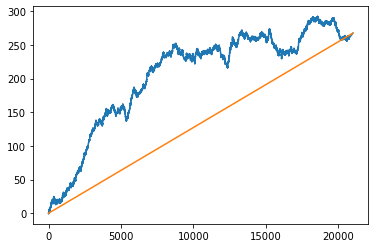

In [16]:
best_auqc, best_param = find_params(n_d = 10, n_a = 10, alpha = [0.7],n_steps = [3], max_epochs= [6], batch_size = [200])

In [58]:
print(best_auqc, best_param)

1170575.1002557792 {'alpha': 0.7, 'batch_size': 200, 'epoch': 6, 'n_steps': 3}


<span style='color:Green'> **AUQC**  </span>: mean:  1170575.1002557792 | std:  330789.0305967369 \
<span style='color:Green'> **uplift30%**</span>: mean:  0.058069956013709144 | std:  0.01021337553738795 \
<span style='color:Green'> **Kendall_rank_correlation**</span>: mean:  0.5462222222222222 | std:  0.15072440120247652 \
<span style='color:Green'> **AUUC**</span>: mean:  0.01905250570045293 | std:  0.005289460001762577

with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 6, 'n_steps': 3}  n_a =  10  n_d =  10

In [59]:
best_auqc, best_param = find_params(n_d = 10, n_a = 10, alpha = [0.9],n_steps = [1], max_epochs= [4,5,6,7,8,9,10,11], batch_size = [200])

search with params:
{'alpha': [0.9],
 'batch_size': [200],
 'epoch': [4, 5, 6, 7, 8, 9, 10, 11],
 'n_steps': [1]}
---iteration  0  --- with  {'alpha': 0.9, 'batch_size': 200, 'epoch': 4, 'n_steps': 1}  n_a =  10  n_d =  10
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.72606 |  0:00:34s
epoch 1  | loss: 0.71111 |  0:01:14s
epoch 2  | loss: 0.70976 |  0:01:55s
epoch 3  | loss: 0.70691 |  0:02:36s
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836


Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank 

Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.86180059523809

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank 

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3777777777

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank

epoch 7  | loss: 0.70284 |  0:04:46s
epoch 8  | loss: 0.70271 |  0:05:22s
epoch 9  | loss: 0.69866 |  0:05:57s
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.422222

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Число замеров 100
AUQC: mean:  304255.2681990398 | std:  345570.70572888345
uplift30%: mean:  0.03560129427934789 | std:  0.010027654758853834
Kendall_rank_correlation: mean:  0.13644444444444445 | std:  0.158965981626975
AUUC: mean:  0.0049214679358229535 | std:  0.005620490906072145
---iteration  7  --- with  {'alpha': 0.9, 'batch_size': 200, 'epoch': 11, 'n_steps': 1}  n_a =  10  n_d =  10
Device 

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation 

In [60]:
print(best_auqc, best_param)

1046938.4852671252 {'alpha': 0.9, 'batch_size': 200, 'epoch': 9, 'n_steps': 1}


In [ ]:
best_auqc, best_param = find_params(n_d = 12, n_a = 12, alpha = [0.1, 0.3, 0.5, 0.7,0.9],n_steps = [1,2,3], max_epochs= [2,4], batch_size = [200])

search with params:
{'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
 'batch_size': [200],
 'epoch': [2, 4, 5],
 'n_steps': [1, 2, 3, 4]}
---iteration  0  --- with  {'alpha': 0.1, 'batch_size': 200, 'epoch': 2, 'n_steps': 1}  n_a =  12  n_d =  12
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.85645 |  0:00:42s
epoch 1  | loss: 1.86333 |  0:01:21s
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Число замеров 100
AUQC

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.7777777777777777 wit

Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.33333333333333

Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  -0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  -0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplif

Kendal uplift rank correlation =  0.22473328748774737 with p_value =  0.36917141633269157
Kendal uplift rank correlation =  -0.044946657497549475 with p_value =  0.8574624419592412
Kendal uplift rank correlation =  0.044946657497549475 with p_value =  0.8574624419592412
Kendal uplift rank correlation =  0.31462660248284624 with p_value =  0.20866778769826422
Kendal uplift rank correlation =  -0.1797866299901979 with p_value =  0.47249761400068846
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
Kendal uplift rank correlation =  -0.13483997249264842 with p_value =  0.5900138871633462
Kendal uplift rank correlation =  0.13483997249264842 with p_value =  0.5900138871633462
Kendal uplift rank correlation =  0.1797866299901979 with p_value =  0.47249761400068846
Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Kendal uplift rank correlation =  0.35957325

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank cor

epoch 2  | loss: 1.86063 |  0:05:04s
epoch 3  | loss: 1.85853 |  0:06:46s
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_v

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Число замеров 100
AUQC: mean:  920639.650761689 | std:  355552.5736113588
uplift30%: mean:  0.05269184296274761 | std:  0.011121596394815294
Kendall_rank_correlation: mean:  0.516 | std:  0.15342715781343133
AUUC: mean:  0.015298565993395494 | std:  0.005735499392183101
---iteration  8  --- with  {'alpha': 0.1, 'batch_size': 200, 'epoch': 5, 'n_steps': 1}  n_a =  12  n_d =  12
Device u

Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.0166

Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank c

Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.1999999999

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_va

Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank cor

Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank c

Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Число замеров 100
AUQC: mean:  369516.6916003107 | std:  282318.16585401504
uplift30%: mean:  0.0285745409832393 | std:  0.008674891978940648
Kendall_rank_correlation: mean:  0.2266666666666666 | std:  0.17114448637441154
AUUC: mean:  0.005969723645385279 | std:  0.004560401291242106
---iteration  15  --- with  {'alpha': 0.3, 'batch_size': 200, 'epoch': 2, 'n_steps': 4}  n_a =  12  n_d =  12
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.58013 |  0:01:38s
epoch 1  | loss: 1.58113 |  0:03:16s
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank c

Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.7333333333333333 with p_value =  0.002212852733686067
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =

Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  -0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  -0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
Kendal uplift rank correlation =

In [ ]:
print(best_auqc,best_param)

In [10]:
best_auqc, best_param = find_params(n_d = 8, n_a = 8, alpha = [0.1, 0.3, 0.5, 0.7,0.9],n_steps = [1,3], max_epochs= [4], batch_size = [200])

search with params:
{'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
 'batch_size': [200],
 'epoch': [4],
 'n_steps': [1, 3]}
---iteration  0  --- with  {'alpha': 0.1, 'batch_size': 200, 'epoch': 4, 'n_steps': 1}  n_a =  8  n_d =  8
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.86495 |  0:00:33s
epoch 1  | loss: 1.8735  |  0:01:10s
epoch 2  | loss: 1.87597 |  0:01:42s
epoch 3  | loss: 1.86605 |  0:02:15s
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  -0.24845199749997662 with p_value =  0.3840882494738521
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.14907119849998599 with p_value =  0.6015081344405899

Kendal uplift rank correlation =  -0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.24845199749997662 with p_value =  0.3840882494738521
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplif

Kendal uplift rank correlation =  -0.36514837167011077 with p_value =  0.18152138952609564
Kendal uplift rank correlation =  -0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  -0.36514837167011077 with p_value =  0.18152138952609564
Kendal uplift rank correlation =  -0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  -0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  -0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  -0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  -0.18257418583505539 with p_value =  0.50410636365208
Kendal uplift rank correlation =  -0.6085806194501846 with p_value =  0.02596005119655662
Kendal uplift rank correlation =  -0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  -0.4868644955601477 with p_value =  0.07483944192187486
Kendal uplif

Kendal uplift rank correlation =  -0.167093470609201 with p_value =  0.5163371619568604
Kendal uplift rank correlation =  -0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  -0.21483446221182986 with p_value =  0.40403816195351605
Kendal uplift rank correlation =  -0.5967623950328607 with p_value =  0.020456721550759997
Kendal uplift rank correlation =  -0.3103164454170876 with p_value =  0.22809167623093418
Kendal uplift rank correlation =  -0.4057984286223453 with p_value =  0.11499183293112152
Kendal uplift rank correlation =  -0.21483446221182986 with p_value =  0.40403816195351605
Kendal uplift rank correlation =  -0.11935247900657214 with p_value =  0.6429538668866239
Kendal uplift rank correlation =  -0.4535394202249742 with p_value =  0.07814087264538563
Kendal uplift rank correlation =  -0.5490214034302319 with p_value =  0.032971123715770254
Kendal uplift rank correlation =  -0.3103164454170876 with p_value =  0.22809167623093418
Kendal u

Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.8222222222222221 with p_value =  0.0003576940035273369
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.333333333

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation = 

Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank co

Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.7777777777777777 with p_value =  0.0009463183421516755
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Число замеров 100
AUQC: mean:  815990.2081298152 | std:  294042.24024667346
uplift30%: mean:  0.04661520427570566 | std:  0.009383325914380724
Kendall_rank_correlation: mean:  0.40088888888888896 | std:  0.15311277424210637
AUUC: mean:  0.013312730199693812 | std:  0.004707771866413897
---iteration  7  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}  n_a =  8  n_d =  8
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.01699 |  0:01:13s
epoch 1  | loss: 1.00911 |  0:0

Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.6 with p_

Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.1111111111111111 with p_value =  0.7274895282186948
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  -0.15555555555555553 with p_value =  0.6006536596119929
Kendal uplift rank correlation =  0.06666666666666667 with p

In [11]:
print(best_auqc,best_param)

1030140.7029636621 {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}


In [12]:
best_auqc, best_param = find_params(n_d = 6, n_a = 6, alpha = [0.1, 0.3, 0.5, 0.7,0.9],n_steps = [1,3], max_epochs= [4], batch_size = [200])

search with params:
{'alpha': [0.1, 0.3, 0.5, 0.7, 0.9],
 'batch_size': [200],
 'epoch': [4],
 'n_steps': [1, 3]}
---iteration  0  --- with  {'alpha': 0.1, 'batch_size': 200, 'epoch': 4, 'n_steps': 1}  n_a =  6  n_d =  6
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.86526 |  0:00:31s
epoch 1  | loss: 1.8709  |  0:01:02s
epoch 2  | loss: 1.87856 |  0:01:34s
epoch 3  | loss: 1.86426 |  0:02:06s
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank

Kendal uplift rank correlation =  0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  -0.12171612389003693 with p_value =  0.6560583341550847
Kendal uplift rank correlation =  0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  0.3042903097250923 with p_value =  0.2655347738734384
Kendal uplift rank correlation =  0.18257418583505539 with p_value =  0.50410636365208
Kendal uplift rank correlation =  0.5477225575051662 with p_value =  0.04505635380146353
Kendal uplift rank correlation =  0.18257418583505539 with p_value =  0.50410636365208
Kendal uplift rank correlation =  0.6694386813952031 with p_value =  0.014305878435429657
Kendal uplift rank correlation =  0.060858061945018464 with p_value =  0.8237838788539289
Kendal uplift rank correlation =  -0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank correlation =  0.24343224778007386 with p_value =  0.3730775013741222
Kendal uplift rank cor

Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.17638342073763935 with p_value =  0.5012411004865837
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank correlation =  0.12598815766974242 with p_value =  0.6309540411841708
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.4283597360771242 with p_value =  0.1024044098198256
Kendal uplift rank correlation =  0.17638342073763935 with p_value =  0.5012411004865837
Kendal uplift rank cor

Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Число замеров 100
AUQC: mean:  540643.2854497315 | std:  315430.7326534611
uplift30%: mean:  0.03992272296902552 | std:  0.009503681003247015
Kendall_rank_correlation: mean:  0.3920751466682383 | std:  0.16017947285507647
AUUC: mean:  0.009044060283411332 | std:  0.005093996595296525
---iteration  3  --- with  {'alpha': 0.3, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}  n_a =  6  n_d =  6
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.60661 |  0:01:11s
epoch 1  | loss: 1.61173 |  0:02:21s
epoch 2  | loss: 1.61394 |  0:03:32s
epoch 3  | loss: 1.60401 |  0:04:43s
Kendal uplift r

Kendal uplift rank correlation =  0.10846522890932808 with p_value =  0.6977358290647567
Kendal uplift rank correlation =  -0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  -0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  0.1084652289

Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.1632993161855452 with p_value =  0.5416914750590134
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.0 with p_value =  1.0
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.6531972647421808 with p_value =  0.014645494331075945
Kendal uplift rank correlation =  0.1632993161855452 with p_value =  0.5416914750590134
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.05443310539518174 with p_value =  0.8388075104761388
Kendal uplift rank correlation =  0.05443310539518174

Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Kendal uplift rank correlation =  nan with p_value =  nan
Число замеров 100
AUQC: mean:  0.0 | std:  0.0
uplift30%: mean:  0.032249057400583175 | std:  0.011259379394136314
Kendall_rank_correlation: mean:  nan | std:  nan
AUUC: mean:  0.0 | std:  0.0
---iteration  6  --- with  {'alpha': 0.7, 'batch_size': 200, 'epoch': 4, 'n_steps': 1}  n_a =  6  n_d =  6
Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.05379 |  0:00:31s
epoch 1  | loss: 1.04842 |  0:01:02s
epoch 2  | loss: 1.05134 |  0:01:34s
epoch 3  | loss: 1.04464 |  0:02:05s
Kendal uplift rank correlation =  0.7811265775524029 wi

Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.37796447300922725 with p_value =  0.14954135458461512
Kendal uplift rank correlation =  0.4787549991450212 with p_value =  0.06793149835836694
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.579545525280815 with p_value =  0.027121231375023425
Kendal uplift rank c

Kendal uplift rank correlation =  -0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  -0.24845199749997662 with p_value =  0.3840882494738521
Kendal uplift rank correlation =  -0.049690399499995326 with p_value =  0.8618044330490109
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.34783279649996723 with p_value =  0.22301746994661498
Kendal uplift rank correlation =  0.14907119849998599 with p_value =  0.6015081344405899
Kendal uplift rank correlation =  0.4472135954999579 with p_value =  0.1171850871981381
Kendal uplift rank

Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.4354648431614539 with p_value =  0.10366227301829672
Kendal uplift rank correlation =  0.3265986323710904 with p_value =  0.22226996949464706
Kendal uplift rank correlation =  0.3810317377662721 with p_value =  0.15446576442708201
Kendal uplift rank correlation =  0.2721655269759087 with p_value =  0.3091081171471306
Kendal uplift rank correlation =  0.5443310539518174 with p_value =  0.041932390923852945
Kendal uplift rank correlation =  0.4898979485566356 with p_value =  0.06713466191406173
Kendal uplift rank cor

Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.2771739468734333 with p_value =  0.2905819610245267
Kendal uplift rank correlation =  0.629940788348712 with p_value =  0.016309171877754974
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank correlation =  0.7811265775524029 with p_value =  0.0028977301317317126
Kendal uplift rank correlation =  0.7307313144845059 with p_value =  0.005332504118163451
Kendal uplift rank correlation =  0.680336051416609 with p_value =  0.00948454933614764
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
Kendal uplift rank correlation =  0.22677868380553634 with p_value =  0.3872078447714531
Kendal uplift rank correlation =  0.529150262212918 with p_value =  0.04363140075597022
Kendal uplift rank corr

In [13]:
print(best_auqc,best_param)

752691.8780275743 {'alpha': 0.9, 'batch_size': 200, 'epoch': 4, 'n_steps': 3}


## классика сиамские сети

In [ ]:
import torch

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from statistics import mean

batch_size = 23 # 250-500  # Number of samples in each batch to do(/9)
batch_size_test=60011  

columns=features.columns
print(columns)

epoch_num = 4  # Number of epochs to train the network
lr = 0.001        # Learning rate

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(334, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        m = nn.Sigmoid()
        return m(x)


model = Model()
alpha = 0.3

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size_test, shuffle=True)


optimizer = optim.Adam(model.parameters(),lr = lr)

# define lists of losses to store
all_losses  = []
test_losses = []
min_losses = []

# epochs loop
for ep in range(epoch_num):  
    model.train()
    print(".......................... epoch =",ep,"..........................")
    batch_loss = []
    # batches loop
    for X_batch_0,X_batch_1, Z_batch, treatment_batch, y_batch in train_loader:
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch

        optimizer.zero_grad()
        # Forward pass (predict)
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        #convert to torch structure
        treatment_batch = treatment_batch
       

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )
        
        ones = np.ones(shape = batch_size)
        ones = torch.from_numpy(ones).float()
              
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 
        
        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class 
    
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
        batch_loss.append(sum_of_losses)
 
        # Backward pass and updates
        sum_of_losses.backward()            # calculate the gradients
        optimizer.step()                    # update the weights
        
        #end for !!!!!!!!!!!!!!!!!!!

    batch_loss  = list(batch_loss)
    all_losses.append( sum(batch_loss) / len(batch_loss) ) 

    # #work with test dataset
    print('work with test dataset')
    batch_loss = []
    
    model.eval()
    
    for X_batch_0,X_batch_1,Z_batch,treatment_batch, y_batch in test_loader:
        
        
        
        batch_1_feat = X_batch_1
        batch_0_feat = X_batch_0
        
        batch_label = y_batch
        batch_Z_trans = Z_batch
        
        mu_1_target_class = model(batch_1_feat)
        mu_0_target_class = model(batch_0_feat)

        mu_0_target_class = torch.reshape(mu_0_target_class, shape = (-1,))
        mu_1_target_class = torch.reshape(mu_1_target_class, shape =(-1,) )

        ones = np.ones(shape = batch_size_test)
        ones = torch.from_numpy(ones).float()
            
        #implements mu = T * mu_1 + (1-T) * mu_0
        uplift_pred_Y = treatment_batch * mu_1_target_class + (ones - treatment_batch) * mu_0_target_class 

        #declare losses
        loss_cross = nn.BCELoss(reduction = 'mean')
        loss_MSE = nn.MSELoss()

        #implements uplift_predicted = mu_1 - mu_0
        uplift_pred = mu_1_target_class - mu_0_target_class   
        

        # scatter plot for mse parametres to do !!!
        sum_of_losses = torch.mean(  (1-alpha) * loss_MSE(batch_Z_trans, uplift_pred) + alpha * loss_cross( uplift_pred_Y, batch_label))
       
        batch_loss.append(sum_of_losses)
        

        
        
        
    #     #end for
    batch_loss  = list(batch_loss)
    test_losses.append( sum(batch_loss) / len(batch_loss) ) 
    

plt.plot(all_losses, color='green',label='train')
plt.title('train vs test')
plt.xlabel('epoch_num')
plt.ylabel('loss sum')

plt.plot(test_losses, color='blue',label='test')
plt.legend()
plt.show()





In [10]:
#batch_size = 200
clf=TabNetClassifier(n_steps=1, seed = 3)
clf

T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=2, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False,alpha = 0.5
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.29278 |  0:00:36s
epoch 1  | loss: 1.2869  |  0:01:16s


In [11]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.24444444444444444 with p_value =  0.38071979717813054
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.022222222222222223 with p_value =  1.0
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
Kendal uplift rank correlation =  

Kendal uplift rank correlation =  0.19999999999999998 with p_value =  0.4843127204585538
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
Число замеров 100
AUQC: mean:  652635.3826161207 | std:  327967.8186005611
uplift30%: mean:  0.04379425550135177 | std:  0.009683321047444751
Kendall_rank_correlation: mean:  0.35200000000000004 | std:  0.1848406222070989
AUUC: mean:  0.0106009334815982 | std:  0.00533359095516206


In [111]:
#batch_size = 200
clf=TabNetClassifier(n_steps=1, seed = 3)
clf

T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=4, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.99525 |  0:00:35s
epoch 1  | loss: 2.00419 |  0:01:08s
epoch 2  | loss: 2.00714 |  0:01:41s
epoch 3  | loss: 1.99603 |  0:02:14s


In [112]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([0.0000e+00, 2.5929e-02, 7.1614e-04,  ..., 6.8841e-03, 1.8914e-07,
        6.8841e-03], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
tensor([6.8841e-03, 6.8841e-03, 6.8841e-03,  ..., 1.8453e-10, 6.8841e-03,
        1.9532e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.0724860850868465
tensor([6.8841e-03, 2.0997e-03, 6.8841e-03,  ..., 8.7013e-04, 6.8841e-03,
        1.0664e-14], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
tensor([2.4715e-10, 1.5028e-04, 6.8841e-03,  ..., 3.2187e-06, 6.8841e-03,
        1.1081e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6741998624632421 with p_value =  0.0070583320485

tensor([1.1921e-07, 5.4836e-06, 6.8841e-03,  ..., 2.0339e-02, 1.1921e-05,
        2.3842e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
tensor([4.2268e-02, 6.8841e-03, 6.8841e-03,  ..., 7.5870e-03, 6.8841e-03,
        8.3868e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
tensor([1.9066e-08, 6.8841e-03, 2.0266e-06,  ..., 1.0884e-03, 6.8841e-03,
        1.1921e-07], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
tensor([6.8841e-03, 1.0511e-10, 6.8841e-03,  ..., 2.5291e-03, 4.7684e-07,
        6.8841e-03], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.0481934882931

tensor([1.1884e-02, 3.4115e-10, 1.0792e-02,  ..., 6.8841e-03, 2.2218e-06,
        6.8841e-03], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
tensor([0.0069, 0.0007, 0.0069,  ..., 0.0069, 0.0069, 0.0003],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
tensor([0.0000e+00, 4.7684e-07, 6.8841e-03,  ..., 2.1590e-06, 1.1921e-07,
        6.9581e-13], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3595732599803958 with p_value =  0.15076277502664528
tensor([6.8841e-03, 2.4202e-08, 1.0442e-05,  ..., 3.6005e-02, 6.8841e-03,
        1.0729e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5843065474681431 with p_value =  0.019550269092885545
tensor([5.7697e-05, 

tensor([5.6028e-06, 6.8841e-03, 3.9266e-07,  ..., 7.7964e-13, 1.5405e-05,
        5.7139e-08], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5393598899705937 with p_value =  0.031141210595796737
Число замеров 100
AUQC: mean:  862803.2831366339 | std:  326925.14111902873
uplift30%: mean:  0.04917275427481391 | std:  0.010860384849523964
Kendall_rank_correlation: mean:  0.43373524485135234 | std:  0.18464414383087163
AUUC: mean:  0.014156036644628887 | std:  0.005277615896671236


In [109]:
#batch_size = 200
clf=TabNetClassifier(n_steps=1, seed = 3)
clf

T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=3, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.99525 |  0:00:31s
epoch 1  | loss: 2.00419 |  0:01:10s
epoch 2  | loss: 2.00714 |  0:01:51s


In [110]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([1.1921e-07, 1.9715e-03, 1.8018e-02,  ..., 3.9007e-03, 3.6357e-04,
        5.5338e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.31462660248284624 with p_value =  0.20866778769826422
tensor([5.5248e-02, 5.8134e-02, 5.5338e-02,  ..., 6.7840e-06, 5.5338e-02,
        3.1042e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
tensor([5.8185e-02, 6.0019e-02, 5.5338e-02,  ..., 5.3170e-02, 5.5338e-02,
        3.6531e-08], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
tensor([7.9945e-06, 1.0499e-02, 5.5338e-02,  ..., 4.5669e-04, 5.5338e-02,
        5.5338e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.44946657497549475 with p_value =  0.07248608508

tensor([0.0487, 0.0553, 0.0553,  ..., 0.0589, 0.0553, 0.0207],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
tensor([9.5623e-05, 5.5338e-02, 2.1076e-04,  ..., 5.5851e-02, 5.5338e-02,
        5.9605e-07], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
tensor([3.7072e-02, 4.9485e-06, 5.5338e-02,  ..., 5.5338e-02, 1.9312e-05,
        3.9125e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.26967994498529685 with p_value =  0.2811980995641792
tensor([0.0157, 0.0372, 0.0002,  ..., 0.0001, 0.0553, 0.0380],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6292532049656925 with p_value =  0.01192100149691403
tensor([0.0039, 0.0079, 0.0553,  ..., 0.0001

tensor([0.0000e+00, 1.1563e-05, 5.5338e-02,  ..., 1.4460e-03, 1.1921e-06,
        3.2651e-07], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4944132324730442 with p_value =  0.04819348829319082
tensor([3.5589e-03, 1.0983e-04, 3.2830e-03,  ..., 2.3145e-04, 3.7918e-02,
        6.9082e-05], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.22473328748774737 with p_value =  0.36917141633269157
tensor([0.0145, 0.0553, 0.0553,  ..., 0.0149, 0.0014, 0.0150],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.40451991747794525 with p_value =  0.10599754842494577
tensor([5.5338e-02, 1.5631e-03, 3.3200e-06,  ..., 3.0518e-05, 5.4027e-02,
        5.3786e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.26967994498529685 with p_value =  0.2811980995641792
tensor([3.3699e-02,

In [106]:
#batch_size = 200
clf=TabNetClassifier(n_steps=1, seed = 3)
clf

T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=2, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.99525 |  0:00:30s
epoch 1  | loss: 2.00419 |  0:01:05s


In [107]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([3.0994e-06, 6.8023e-02, 4.9058e-03,  ..., 2.8932e-04, 5.7914e-06,
        5.0259e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.15555555555555553 with p_value =  0.6006536596119929
tensor([6.8336e-02, 6.6339e-02, 3.7541e-02,  ..., 9.9428e-09, 6.8023e-02,
        4.1097e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
tensor([5.8903e-02, 6.7624e-02, 6.8023e-02,  ..., 5.5299e-03, 6.8023e-02,
        1.4169e-12], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
tensor([1.2987e-08, 1.7373e-03, 6.8023e-02,  ..., 1.3382e-03, 2.1477e-03,
        6.8023e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195

tensor([1.3709e-05, 8.4639e-06, 1.8764e-04,  ..., 4.6188e-02, 6.4239e-03,
        8.7339e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
tensor([0.0387, 0.0680, 0.0680,  ..., 0.0660, 0.0680, 0.0002],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
tensor([6.9731e-07, 6.8023e-02, 7.1800e-04,  ..., 6.3021e-02, 6.8023e-02,
        8.1062e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6888888888888888 with p_value =  0.00468694885361552
tensor([6.8023e-02, 5.9450e-09, 1.3793e-04,  ..., 5.8297e-02, 1.0663e-04,
        6.8023e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
tensor([6.8023e-02, 4

tensor([0.0042, 0.0047, 0.0680,  ..., 0.0680, 0.0680, 0.0465],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
tensor([9.5367e-07, 7.1943e-05, 4.1373e-04,  ..., 5.3793e-05, 1.2994e-05,
        6.1329e-11], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6 with p_value =  0.016666115520282188
tensor([6.8023e-02, 8.6858e-07, 2.1447e-04,  ..., 8.7800e-09, 6.8023e-02,
        2.9153e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
tensor([2.3005e-02, 6.8023e-02, 7.9179e-03,  ..., 3.3764e-03, 4.6328e-05,
        2.3585e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4666666666666666 with p_value =  0.07255015432098766
tensor([6.8023e-02, 6.1192e-05, 6.8

In [108]:
# save tabnet model
saving_path_name = "./tabnet_model_test_2"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_2.zip


In [94]:
#batch_size = 20000
clf=TabNetClassifier(n_steps=1, seed = 3)
clf

T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=7, patience=20,batch_size=20000, num_workers=0,
    weights=1, drop_last=False
) 

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.997   |  0:00:27s
epoch 1  | loss: 2.00483 |  0:00:51s
epoch 2  | loss: 2.00812 |  0:01:15s
epoch 3  | loss: 1.99659 |  0:01:38s
epoch 4  | loss: 1.9953  |  0:02:02s
epoch 5  | loss: 2.01297 |  0:02:26s
epoch 6  | loss: 2.0004  |  0:02:53s


In [95]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([-0.0097, -0.0095, -0.0098,  ..., -0.0099, -0.0093, -0.0066],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.37777777777777777 with p_value =  0.1557418430335097
tensor([-0.0055, -0.0096, -0.0109,  ..., -0.0097, -0.0096, -0.0096],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.06666666666666667 with p_value =  0.8618005952380953
tensor([-0.0006, -0.0109, -0.0055,  ..., -0.0054, -0.0081, -0.0106],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
tensor([-0.0053, -0.0088, -0.0100,  ..., -0.0109, -0.0068, -0.0088],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5555555555555555 with p_value =  0.02860945767195767
tensor([-0.0109, -0.0101, -0.0109,  ..., -0.0092, -0.0103, -0.0105],
   

tensor([-0.0099, -0.0108, -0.0094,  ..., -0.0105, -0.0106, -0.0002],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4222222222222222 with p_value =  0.10831349206349207
tensor([-9.4395e-03, -9.8838e-03, -9.9799e-03,  ..., -2.3842e-07,
        -9.9273e-03, -1.0899e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6444444444444444 with p_value =  0.009148478835978836
tensor([-0.0095, -0.0016, -0.0070,  ..., -0.0099, -0.0097, -0.0093],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
tensor([-0.0102, -0.0109, -0.0096,  ..., -0.0097, -0.0109, -0.0100],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5111111111111111 with p_value =  0.04662257495590829
tensor([-0.0098, -0.0100, -0.0075,  ..., -0.01

tensor([-0.0101, -0.0107, -0.0028,  ..., -0.0109, -0.0109, -0.0101],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
tensor([-0.0018, -0.0103, -0.0098,  ..., -0.0103, -0.0097, -0.0025],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.28888888888888886 with p_value =  0.2912483465608466
tensor([-0.0100, -0.0043, -0.0107,  ..., -0.0094, -0.0101, -0.0106],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3333333333333333 with p_value =  0.21637345679012346
tensor([-0.0107, -0.0102, -0.0029,  ..., -0.0109, -0.0103, -0.0035],
       grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  -0.022222222222222223 with p_value =  1.0
tensor([-5.8954e-03, -9.8345e-03, -2.3842e-07,  ..., -9.7443e-03,
        -5.8826e-03

In [88]:
clf=TabNetClassifier(n_steps=1, seed = 3)
clf


Device used : cpu


TabNetClassifier(n_d=8, n_a=8, n_steps=1, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=3, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=None, output_dim=None, device_name='auto')

In [89]:
T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn[0:100000,],T_train = T_train[0:100000], y_train=target_learn[0:100000],
    max_epochs=7, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False
) 

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.9986  |  0:00:21s
epoch 1  | loss: 2.0015  |  0:00:44s
epoch 2  | loss: 1.99672 |  0:01:06s
epoch 3  | loss: 1.99815 |  0:01:30s
epoch 4  | loss: 1.99921 |  0:01:54s
epoch 5  | loss: 2.00019 |  0:02:17s
epoch 6  | loss: 1.99375 |  0:02:40s


In [90]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([3.7392e-09, 1.0377e-04, 3.7392e-09,  ..., 3.7392e-09, 3.7392e-09,
        1.0532e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
tensor([1.0812e-04, 1.1081e-04, 3.7392e-09,  ..., 3.7392e-09, 3.7392e-09,
        1.3518e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6922443782381184 with p_value =  0.007172611024885319
tensor([3.7392e-09, 3.7392e-09, 1.1212e-04,  ..., 3.7392e-09, 1.0437e-04,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.26257545381445874 with p_value =  0.3077948174161401
tensor([1.0377e-04, 3.7392e-09, 3.7392e-09,  ..., 1.1355e-04, 3.7392e-09,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.167093470609201 with p_value =  0.51633716195686

tensor([1.1390e-04, 3.7392e-09, 3.7392e-09,  ..., 1.3000e-04, 1.1092e-04,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
tensor([3.7392e-09, 3.7392e-09, 1.0961e-04,  ..., 3.7392e-09, 1.1641e-04,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4057984286223453 with p_value =  0.11499183293112152
tensor([3.7392e-09, 3.7392e-09, 3.7392e-09,  ..., 3.7392e-09, 3.7392e-09,
        1.2189e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3103164454170876 with p_value =  0.22809167623093418
tensor([1.0884e-04, 3.7392e-09, 3.7392e-09,  ..., 3.7392e-09, 1.0848e-04,
        1.2797e-04], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3103164454170876 with p_value =  0.22809167623093

tensor([2.0748e-04, 3.7392e-09, 3.7392e-09,  ..., 1.0854e-04, 3.7392e-09,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.501280411827603 with p_value =  0.05153405901703818
tensor([2.9731e-04, 3.7392e-09, 3.7392e-09,  ..., 3.7392e-09, 3.7392e-09,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.11935247900657214 with p_value =  0.6429538668866239
tensor([3.7392e-09, 3.7392e-09, 3.7392e-09,  ..., 3.7392e-09, 1.1045e-04,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.32756920994133026 with p_value =  0.2116652202692184
tensor([1.2565e-04, 1.0705e-04, 1.5247e-04,  ..., 3.7392e-09, 3.7392e-09,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.501280411827603 with p_value =  0.0515340590170381

tensor([3.1793e-05, 3.7392e-09, 3.7392e-09,  ..., 1.0592e-04, 1.4782e-04,
        3.7392e-09], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.26257545381445874 with p_value =  0.3077948174161401
Число замеров 100
AUQC: mean:  528484.0664436453 | std:  298354.4703472236
uplift30%: mean:  0.04798011613398599 | std:  0.009814603501570224
Kendall_rank_correlation: mean:  0.32640311552683554 | std:  0.1897303891225103
AUUC: mean:  0.00843760770761579 | std:  0.0048447091936124126


In [91]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


## best

In [ ]:
clf=TabNetClassifier(n_steps=1, seed = 3)
clf


In [12]:
T_train = treatment_learn


# print(X_learn.shape)
# print(T_train.shape)
# print(target_learn.shape)



clf.fit(
    X_train=X_learn,T_train = T_train, y_train=target_learn,
    max_epochs=7, patience=20,batch_size=200, num_workers=0,
    weights=1, drop_last=False
) 

No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.99461 |  0:01:02s
epoch 1  | loss: 1.99613 |  0:02:01s
epoch 2  | loss: 2.00446 |  0:02:55s
epoch 3  | loss: 2.00546 |  0:03:50s
epoch 4  | loss: 1.99561 |  0:04:48s
epoch 5  | loss: 2.00324 |  0:05:47s
epoch 6  | loss: 1.99047 |  0:06:44s


In [33]:
from uplift.metrics import Kendall_rank_correlation, qini_auc_score, uplift_at_k

all_res_uplift = []
all_res_auqc = []
all_res_rank_correlation = []
all_res_auuc = []

for j in range( 1, 101, 1):

    RANDOM_STATE = j
    indices_learn_new, indices_valid_new = train_test_split(
        NEW.index,
        test_size=0.35,
        random_state = RANDOM_STATE,
    )
   

    X_valid = NEW.loc[indices_valid_new, :].values
    treatment_valid = NEW_train.loc[indices_valid_new, 'treatment_flg'].values
    target_valid = NEW_train.loc[indices_valid_new, 'target'].values

#     print(X_valid)
    preds = clf.predict_proba(X_valid)
    valid_pred  = preds.reshape(-1)
    
    # valid_pred = clf.predict(X_valid)
    AUQC = qini_auc_score(target_valid, valid_pred, treatment_valid)
   
    valid_scores = uplift_at_k(target_valid, valid_pred, treatment_valid)
    tau, p_value = Kendall_rank_correlation(target_valid, valid_pred, treatment_valid)
    auuc = uplift_auc_score(target_valid, valid_pred, treatment_valid)
    
    all_res_uplift.append(valid_scores)
    all_res_auqc.append(AUQC)
    all_res_rank_correlation.append(tau)
    all_res_auuc.append(auuc)
    
print('Число замеров', j)
print('AUQC: mean: ', np.mean(all_res_auqc),"| std: ", np.std(all_res_auqc, ddof=1))
print('uplift30%: mean: ', np.mean(all_res_uplift),"| std: ",np.std(all_res_uplift, ddof=1))
print('Kendall_rank_correlation: mean: ',np.mean(all_res_rank_correlation), "| std: ", np.std(all_res_rank_correlation,ddof=1))
print('AUUC: mean: ',np.mean(all_res_auuc), "| std: ", np.std(all_res_auuc,ddof=1))

tensor([2.5034e-06, 1.4641e-02, 2.5034e-06,  ..., 1.4641e-02, 2.5034e-06,
        2.5034e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.2500645911391736 with p_value =  0.3212772414140661
tensor([2.5034e-06, 1.4641e-02, 2.5034e-06,  ..., 1.4641e-02, 1.4641e-02,
        1.7524e-05], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.6137949055234262 with p_value =  0.014912049655215961
tensor([2.5034e-06, 2.5034e-06, 2.2451e-02,  ..., 2.5034e-06, 2.2451e-02,
        2.5034e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.47739603762933147 with p_value =  0.058290580139488776
tensor([2.5034e-06, 1.4641e-02, 2.2451e-02,  ..., 2.5034e-06, 2.2451e-02,
        1.4641e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.7501937734175208 with p_value =  0.002925020095

tensor([2.5034e-06, 2.5034e-06, 2.5034e-06,  ..., 2.5034e-06, 2.5034e-06,
        2.5034e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.5683286162253945 with p_value =  0.024185218322711276
tensor([2.2451e-02, 1.4641e-02, 2.2451e-02,  ..., 2.0027e-05, 2.2451e-02,
        1.4641e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.8865926413116155 with p_value =  0.0004372575927067343
tensor([3.8505e-05, 1.4641e-02, 2.2650e-05,  ..., 2.5034e-06, 2.2451e-02,
        2.5034e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4319297483312999 with p_value =  0.08668084494669369
tensor([1.4641e-02, 2.5034e-06, 2.2451e-02,  ..., 2.5034e-06, 2.5034e-06,
        1.4641e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.29553088043720516 with p_value =  0.2411285996

tensor([1.4641e-02, 2.5034e-06, 1.4641e-02,  ..., 1.4641e-02, 1.4641e-02,
        1.4641e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.15913201254311046 with p_value =  0.5279301962697657
tensor([1.4641e-02, 2.5034e-06, 2.2451e-02,  ..., 2.2451e-02, 1.4641e-02,
        2.2451e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3409971697352368 with p_value =  0.17621399555130557
tensor([2.5034e-06, 1.4641e-02, 2.2451e-02,  ..., 2.2451e-02, 2.5034e-06,
        2.2452e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.3409971697352368 with p_value =  0.17621399555130557
tensor([1.4641e-02, 2.5034e-06, 2.2451e-02,  ..., 1.4641e-02, 1.4641e-02,
        1.4641e-02], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.522862326927363 with p_value =  0.038094158061095

tensor([2.5034e-06, 2.2451e-02, 2.5034e-06,  ..., 2.5034e-06, 1.9193e-05,
        2.5034e-06], grad_fn=<SubBackward0>)
torch.Size([21004])
<class 'torch.Tensor'>
Kendal uplift rank correlation =  0.4319297483312999 with p_value =  0.08668084494669369
Число замеров 100
AUQC: mean:  952149.4779270532 | std:  360236.38374201616
uplift30%: mean:  0.046026834552494005 | std:  0.012141481312776457
Kendall_rank_correlation: mean:  0.46693879109078423 | std:  0.16549726781101717
AUUC: mean:  0.01565831289464123 | std:  0.005819560907323952


In [13]:
# 7 epochs
preds = clf.predict_proba(X_valid)
print(preds)

preds_norm  = preds.reshape(-1)
print(preds_norm)

from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score
from uplift.metrics import qini_percentile

 
print(uplift_at_k(target_valid, preds.reshape(-1), treatment_valid))
print(qini_auc_score(target_valid, preds.reshape(-1), treatment_valid))
qini_percentile(target_valid, preds.reshape(-1), treatment_valid)

tensor([1.4641e-02, 1.4641e-02, 2.2451e-02,  ..., 2.5034e-06, 1.4641e-02,
        3.9101e-05], grad_fn=<SubBackward0>)
torch.Size([60011])
<class 'torch.Tensor'>
[[1.4640838e-02 1.4640838e-02 2.2450805e-02 ... 2.5033951e-06
  1.4640838e-02 3.9100647e-05]]
[1.4640838e-02 1.4640838e-02 2.2450805e-02 ... 2.5033951e-06 1.4640838e-02
 3.9100647e-05]
0.04607750182127157
8440642.555960938
              n  target_class  uplift_score
0      0.000017             1  2.246189e-02
1      0.000033             1  2.245992e-02
2      0.000050             3  2.245685e-02
3      0.000075             2  2.245554e-02
4      0.000075             0  2.245554e-02
5      0.000100             1  2.245519e-02
6      0.000117             2  2.245504e-02
7      0.000450             1  2.245456e-02
8      0.000450             2  2.245456e-02
9      0.000450             3  2.245456e-02
10     0.000450             3  2.245456e-02
11     0.000450             2  2.245456e-02
12     0.000450             1  2.245456e-02

In [9]:
# 2 epochs
preds = clf.predict_proba(X_valid)
print(preds)

tensor([0.0046, 0.0046, 0.0226,  ..., 0.0226, 0.0021, 0.0226],
       grad_fn=<SubBackward0>)
torch.Size([60011])
<class 'torch.Tensor'>
[[0.00461523 0.00463231 0.02263112 ... 0.02263112 0.0021174  0.02263112]]


In [10]:
preds_norm  = preds.reshape(-1)
print(preds_norm)

from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score
from uplift.metrics import qini_percentile

 
print(uplift_at_k(target_valid, preds.reshape(-1), treatment_valid))
print(qini_auc_score(target_valid, preds.reshape(-1), treatment_valid))
qini_percentile(target_valid, preds.reshape(-1), treatment_valid)

[0.00461523 0.00463231 0.02263112 ... 0.02263112 0.0021174  0.02263112]


0.02259583649713992
-3881679.0805478357
              n  target_class  uplift_score
0      0.000033             3      0.030115
1      0.000033             0      0.030115
2      0.000033             1      0.030115
3      0.000067             1      0.030115
4      0.000092             2      0.030115
5      0.000092             1      0.030115
6      0.000117             1      0.030115
7      0.000133             2      0.030115
8      0.000150             1      0.030115
9      0.000175             0      0.030114
10     0.000175             0      0.030114
11     0.000200             2      0.030114
12     0.000217             2      0.030114
13     0.000242             1      0.030114
14     0.000242             3      0.030114
15     0.000267             2      0.030114
16     0.000283             2      0.030114
17     0.000300             2      0.030114
18     0.000317             0      0.030114
19     0.000333             0      0.030114
20     0.000358             1      0

### признаки без стандартизации

In [9]:
T_train = treatment_learn

clf.fit(
    X_train=X_learn.values,T_train=T_train, y_train=target_learn,
    max_epochs=10 , patience=20,batch_size=200,
    num_workers=0,
    weights=1,
    drop_last=False
) 

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
preds = clf.predict(X_valid[0:60000])
print(preds)

In [ ]:
print(type(preds))
print(preds.shape)


In [ ]:
preds = clf.predict_proba(X_valid[0:60000])
print(preds)

In [ ]:
preds_norm  = preds.reshape(-1)
print(preds_norm)

In [ ]:
from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score
from uplift.metrics import qini_percentile

 
print(uplift_at_k(target_valid[0:60000], preds_norm, treatment_valid[0:60000]))
print(qini_auc_score(target_valid[0:60000], preds_norm, treatment_valid[0:60000]))
qini_percentile(target_valid[0:60000], preds_norm, treatment_valid[0:60000])

In [ ]:
print(preds*1000)

In [ ]:
preds = preds.reshape(200,1)



In [ ]:
print(preds.reshape(-1))

In [ ]:
from uplift.metrics import uplift_at_k
from uplift.metrics import qini_auc_score
from uplift.metrics import qini_percentile

 
print(uplift_at_k(target_valid[0:60000], preds.reshape(-1), treatment_valid[0:60000]))
print(qini_auc_score(target_valid[0:60000], preds.reshape(-1), treatment_valid[0:60000]))
qini_percentile(target_valid[0:60000], preds.reshape(-1), treatment_valid[0:60000])

In [ ]:
preds = clf.predict_proba(X_valid.values)
print(preds)

In [ ]:
T_train = np.random.randint(2, size=X_train.shape[0])
clf.fit(
    X_train=X_train,T_train=T_train, y_train=y_train,
    eval_set=[(X_train, T_train, y_train)],
    eval_name=['train'],
    eval_metric=['auc'],
    max_epochs=10 , patience=20,

    num_workers=0,
    weights=1,
    drop_last=False
) 

In [ ]:
# plot losses
plt.plot(clf.history['loss'])

In [ ]:
# plot auc
plt.plot(clf.history['train_auc'])


In [ ]:
# plot learning rates
plt.plot(clf.history['lr'])

In [ ]:
preds = clf.predict_proba(X_test)
print(preds)

In [ ]:
print(preds[:,1]-preds[:,0])

## Predictions

In [ ]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

In [ ]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

In [ ]:
clf.predict(X_test)

# Save and load Model

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

In [ ]:
assert(test_auc == loaded_test_auc)

In [ ]:
loaded_clf.predict(X_test)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

In [ ]:
preds = np.array(clf_xgb.predict_proba(X_valid))
valid_auc = roc_auc_score(y_score=preds[:,1], y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict_proba(X_test))
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
print(test_auc)